In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.interpolate import interp1d, RectBivariateSpline

from scipy.optimize import root

In [2]:
common_settings = {
'omega_b':0.0223828,
'h':0.67810,
'z_reio':7.6711,
'YHe':0.25,
'perturbations_verbose':1,
'background_verbose':3,
'output':'mTk, vTk, mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':10,
'z_max_pk':1000,
'format':'class',

# 'omega_cdm':0.4363,
'omega_cdm':0.11,

}

In [3]:
chiCDM = Class()
# pass input parameters
Mnu=0.1
chiCDM.set(common_settings)
aNR=5e-4
aNR=1/1890/Mnu+2.42e-3

print(f'aNR={aNR},zNR={1/aNR -1}')
chiCDM.set({
'N_ur': 3.046,
'omega_chi':0.00107363 ,
# 'omega_cdm':0.90,
# 'f_chi':0.1,
'acs_chi':aNR,
'cs2_peak_chi':1./3.
})


chiCDM.compute()


aNR=0.007711005291005291,zNR=128.6847767912281
Running CLASS version v3.2.0
Computing background
Chose ndf15 as generic_evolver
 -> age = 14.024724 Gyr
 -> conformal age = 14522.420249 Mpc
 -> N_eff = 3.046 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3188.906765
    corresponding to conformal time = 120.369448 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0486773       , omega = 0.0223828      
-> Cold Dark Matter               Omega = 0.239224        , omega = 0.11           
-> Dark Matter with sound speed:  Omega = 0.00233489      , omega = 0.00107363     
 ---> Relativistic Species 
-> Photons                        Omega = 5.37815e-05     , omega = 2.47298e-05    
-> Ultra-relativistic relics      Omega = 3.72044e-05     , omega = 1.71073e-05    
 ---> Other Content 
-> Cosmological Constant          Omega = 0.709673  

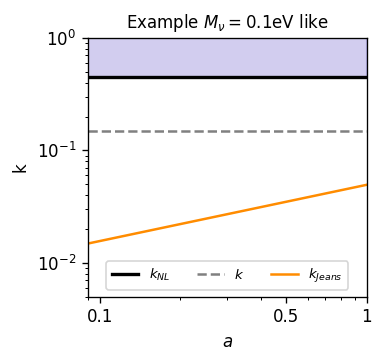

In [4]:

background = chiCDM.get_background() # load background table
h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc

a = 1/(background['z']+1) # read redshift

kJ_chi=background['(.)kJ_chi']
plt.figure(figsize=(3,2.8),dpi=120)

plt.axhline(y=0.45, color='black',label=r'$k_{NL}$', linewidth=2)
plt.axhline(y=0.15, color='gray',label=r'$k$', linewidth=1.5, linestyle='--')

plt.fill_between(a, 0.45, y2=4, color='slateblue', alpha=0.3)
plt.loglog(a,kJ_chi,'darkorange',label=r'$k_{Jeans}$', linewidth=1.5)

plt.xticks([0.1,0.5,1], labels=['0.1','0.5','1'])
plt.xlim([0.9e-1,1])
plt.ylim([0.005,1.])
plt.title(r'Example $M_\nu=0.1\mathrm{eV}$ like', fontsize=10)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(loc='lower center', ncol=3, fontsize=8)

plt.xlabel(r'$a$')
plt.ylabel(r'k')

# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/kFS_kNL_Mnu01.pdf',bbox_inches='tight')
#
plt.show()

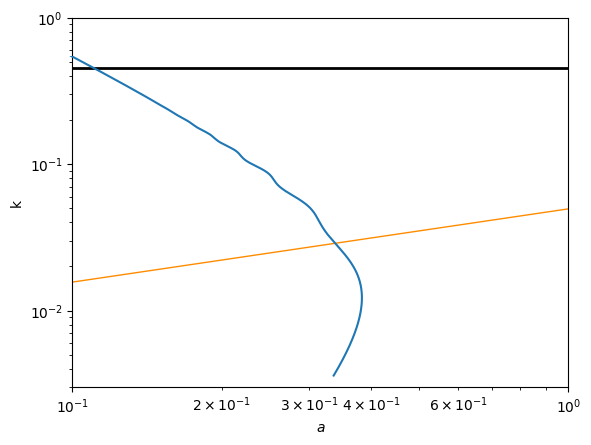

In [6]:

background = chiCDM.get_background() # load background table
h = chiCDM.h() # get reduced Hubble for conversions to 1/Mpc

a = 1/(background['z']+1) # read redshift

kJ_chi=background['(.)kJ_chi']


kk = np.logspace(-2.4,np.log10(1),500) # k in h/Mpc
Pk = [] # P(k) in (Mpc/h)**3
for k in kk:
    Pk.append(chiCDM.pk_lin(k*h,0.)*10) # function .pk(k,z)
Pk=np.array(Pk)

fig, ax = plt.subplots()

ax.loglog(a,kJ_chi,'darkorange',label=r'$k_{J}$ of $\chi$', linewidth=1)
# ax.loglog(Pk,kk, linewidth=1)

ax.axhline(y=0.45, color='black', linewidth=2)

ax_sub = fig.add_axes([0.1, 0.1, 0.5, 0.7], sharey=ax)
ax_sub.loglog(Pk,kk)  # Plot the function vertically
ax_sub.axis('off')  # Remove the axes
# ax_sub.set_xlim([1.e-2,0.2])

ax.set_xlim([1.e-1,1])
ax.set_ylim([3.e-3,1.])
# plt.title(r'Example with $M_\nu=0.1\mathrm{eV}$', fontsize=10)
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xlabel(r'$a$')
ax.set_ylabel(r'k')
# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/kFS_kF_Mnu01.pdf',bbox_inches='tight')
#
plt.show()

In [7]:
aeval = np.logspace(-1,0,100)
k_vals = chiCDM.get_transfer(z=0)['k (h/Mpc)']
d_chi_k = []; d_cdm_k=[]
for av in aeval:
    d_chi_k.append(chiCDM.get_transfer(z=1/av-1)['d_chi'])
    d_cdm_k.append(chiCDM.get_transfer(z=1/av-1)['d_cdm'])
Tratio = np.array(d_chi_k)/np.array(d_cdm_k)
Aeval, K_vals = np.meshgrid(aeval,k_vals)

Tratio_int = RectBivariateSpline(aeval, k_vals,Tratio)

(124, 100) (124, 100) (100, 300)


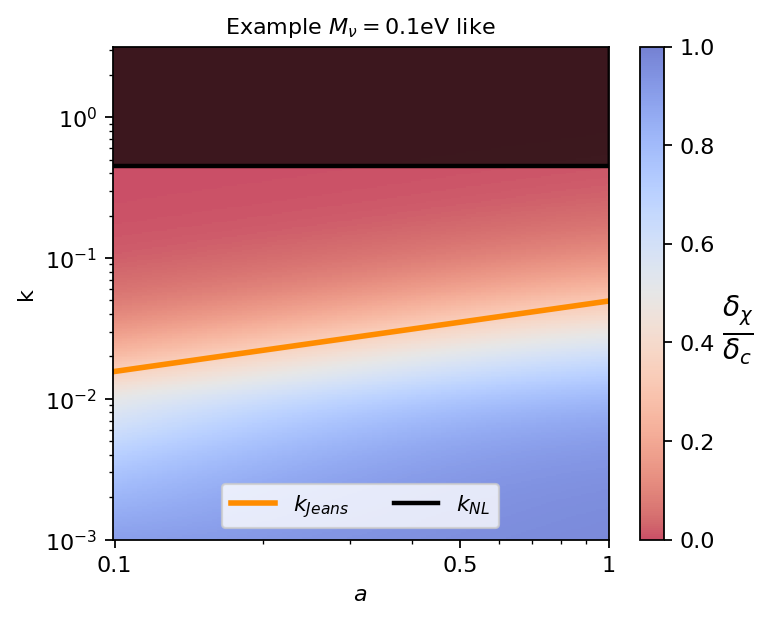

In [10]:
# # Display the data
# Generate a finer grid
kplot = np.logspace(-3,0.5,300)
Anew, Knew = np.meshgrid(aeval, kplot)

plt.figure(figsize=(5,4),dpi=160)

Tratio_img = Tratio_int(aeval, kplot)
print(np.shape(Aeval),K_vals.shape, Tratio_img.shape)
plt.pcolormesh(Anew, Knew, Tratio_img.T, cmap='coolwarm_r', vmin=0, vmax=1, alpha=0.7)
cbar = plt.colorbar()
cbar.set_label(r'$\frac{\delta_\chi}{\delta_c}$', rotation=0, labelpad=10, fontsize=18)

plt.plot(a,kJ_chi,'darkorange',label=r'$k_{Jeans}$', linewidth=2.5)
plt.fill_between(a, 0.45, y2=4, color='black', alpha=0.7)
plt.axhline(y=0.45, color='black',label=r'$k_{NL}$', linewidth=2)

plt.yscale('log')
plt.xscale('log')
plt.legend(loc='lower center', ncol=3, fontsize=10)
plt.title(r'Example $M_\nu=0.1\mathrm{eV}$ like', fontsize=10)

plt.xticks([0.1,0.5,1], labels=['0.1','0.5','1'])
plt.xlim([np.min(aeval)-0.001,np.max(aeval)])
plt.ylim([np.min(kplot),np.max(kplot)])
plt.xlabel(r'$a$')
plt.ylabel(r'k')
plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/kFS_kNL_gradient.png',bbox_inches='tight')

plt.show()